In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/NKG Historical Data.csv', sep=";")
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 12s 311ms/step - loss: 0.0409 - val_loss: 0.0033
Epoch 2/100
13/13 [==============================] - 2s 188ms/step - loss: 0.0087 - val_loss: 0.0032
Epoch 3/100
13/13 [==============================] - 3s 240ms/step - loss: 0.0049 - val_loss: 3.9480e-04
Epoch 4/100
13/13 [==============================] - 3s 255ms/step - loss: 0.0043 - val_loss: 3.4923e-04
Epoch 5/100
13/13 [==============================] - 2s 179ms/step - loss: 0.0042 - val_loss: 1.1021e-04
Epoch 6/100
13/13 [==============================] - 2s 179ms/step - loss: 0.0035 - val_loss: 1.5585e-04
Epoch 7/100
13/13 [==============================] - 2s 182ms/step - loss: 0.0030 - val_loss: 1.7237e-04
Epoch 8/100
13/13 [==============================] - 3s 229ms/step - loss: 0.0027 - val_loss: 1.0844e-04
Epoch 9/100
13/13 [==============================] - 4s 285ms/step - loss: 0.0024 - val_loss: 9.8597e-05
Epoch 10/100
13/13 [==============================] - 3s 196ms

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

9/9 [==============================] - 0s 42ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 4.580389492318821


In [14]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-100:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.02592989 0.0267142  0.02623886 0.02764112 0.02811646 0.02811646
 0.02811646 0.02842543 0.02842543 0.02968509 0.03030303 0.03030303
 0.02904337 0.02904337 0.02780749 0.02733214 0.02890077 0.02890077
 0.030612   0.02811646 0.03122995 0.03139632 0.0287344  0.02935235
 0.03232323 0.03122995 0.02654783 0.0268568  0.02716578 0.02780749
 0.02890077 0.02920974 0.02842543 0.0268568  0.02702317 0.02716578
 0.02592989 0.02576352 0.02795009 0.02904337 0.02968509 0.02780749
 0.02545455 0.02982769 0.02968509 0.03122995 0.02890077 0.02982769
 0.02999406 0.02982769 0.02968509 0.02968509 0.02825906 0.02780749
 0.02733214 0.02702317 0.02654783 0.02890077 0.03358289 0.03372549
 0.03686275 0.03591206 0.03700535 0.03529412 0.03529412 0.03748069
 0.03622103 0.03795603 0.04387403 0.04670232 0.04762923 0.04530006
 0.04530006 0.05029115 0.04998217 0.0554486  0.05295306 0.04606061
 0.04606061 0.04530006 0.04530006 0.04342246 0.04263815 0.04106952
 0.04451575 0.04387403 0.04544266 0.04434938 0.045

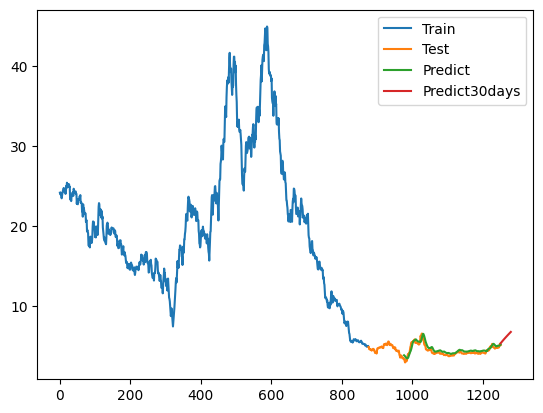

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [16]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-100:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.02592989 0.0267142  0.02623886 0.02764112 0.02811646 0.02811646
 0.02811646 0.02842543 0.02842543 0.02968509 0.03030303 0.03030303
 0.02904337 0.02904337 0.02780749 0.02733214 0.02890077 0.02890077
 0.030612   0.02811646 0.03122995 0.03139632 0.0287344  0.02935235
 0.03232323 0.03122995 0.02654783 0.0268568  0.02716578 0.02780749
 0.02890077 0.02920974 0.02842543 0.0268568  0.02702317 0.02716578
 0.02592989 0.02576352 0.02795009 0.02904337 0.02968509 0.02780749
 0.02545455 0.02982769 0.02968509 0.03122995 0.02890077 0.02982769
 0.02999406 0.02982769 0.02968509 0.02968509 0.02825906 0.02780749
 0.02733214 0.02702317 0.02654783 0.02890077 0.03358289 0.03372549
 0.03686275 0.03591206 0.03700535 0.03529412 0.03529412 0.03748069
 0.03622103 0.03795603 0.04387403 0.04670232 0.04762923 0.04530006
 0.04530006 0.05029115 0.04998217 0.0554486  0.05295306 0.04606061
 0.04606061 0.04530006 0.04530006 0.04342246 0.04263815 0.04106952
 0.04451575 0.04387403 0.04544266 0.04434938 0.045

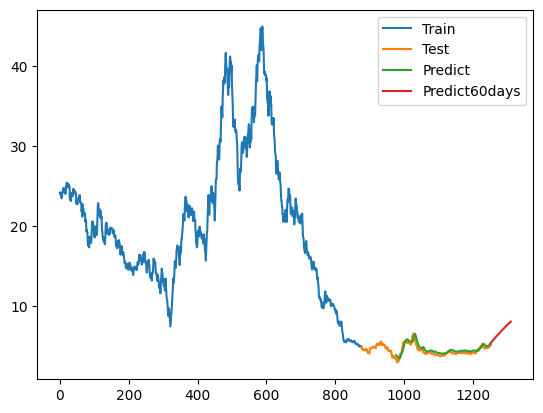

In [20]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 59, step=1)

lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict60days')

plt.legend()
plt.show()

In [21]:
# Chuyển đổi dữ liệu kiểm tra thành danh sách
x_input = test_data[60:].reshape(1, -1)
temp_input = list(x_input[0])

from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # Chuẩn bị dữ liệu đầu vào mới
        x_input = np.array(temp_input[-100:])  # Lấy đúng 100 phần tử cuối cùng
        print("{} day input {}".format(i, x_input))

        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))

        # Thêm giá trị dự đoán vào danh sách tạm thời
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))

        lst_output.extend(yhat.tolist())
        i += 1


0 day input [0.02592989 0.0267142  0.02623886 0.02764112 0.02811646 0.02811646
 0.02811646 0.02842543 0.02842543 0.02968509 0.03030303 0.03030303
 0.02904337 0.02904337 0.02780749 0.02733214 0.02890077 0.02890077
 0.030612   0.02811646 0.03122995 0.03139632 0.0287344  0.02935235
 0.03232323 0.03122995 0.02654783 0.0268568  0.02716578 0.02780749
 0.02890077 0.02920974 0.02842543 0.0268568  0.02702317 0.02716578
 0.02592989 0.02576352 0.02795009 0.02904337 0.02968509 0.02780749
 0.02545455 0.02982769 0.02968509 0.03122995 0.02890077 0.02982769
 0.02999406 0.02982769 0.02968509 0.02968509 0.02825906 0.02780749
 0.02733214 0.02702317 0.02654783 0.02890077 0.03358289 0.03372549
 0.03686275 0.03591206 0.03700535 0.03529412 0.03529412 0.03748069
 0.03622103 0.03795603 0.04387403 0.04670232 0.04762923 0.04530006
 0.04530006 0.05029115 0.04998217 0.0554486  0.05295306 0.04606061
 0.04606061 0.04530006 0.04530006 0.04342246 0.04263815 0.04106952
 0.04451575 0.04387403 0.04544266 0.04434938 0.045

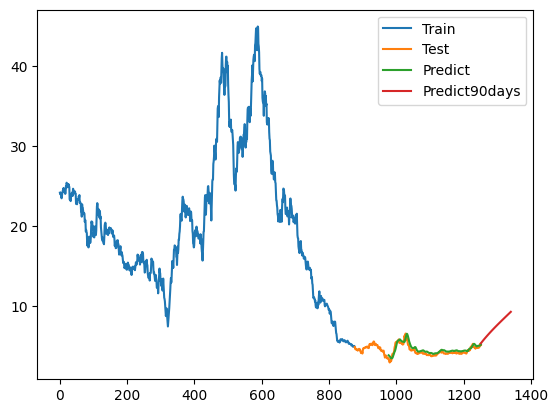

In [22]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Chỉ số cho dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Chỉ số cho dữ liệu dự đoán
pred_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(pred_data_index, y_pred, label='Predict')

# Chỉ số cho dữ liệu dự báo 90 ngày
predict_data_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 89, step=1)

# Chuyển đổi lst_output thành dạng phù hợp
lst_output_flat = np.array(lst_output).reshape(-1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output_flat.reshape(-1, 1)), label='Predict90days')

# Hiển thị đồ thị
plt.legend()
plt.show()